In [2]:
import os
import re
import random
import time
from glob import glob

import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform

In [29]:
# royal_blue = [0, 20/256, 82/256]

def get_tag_paths(zebfolderpath):
    tag = re.findall(r'z.*f\d+', zebfolderpath)[0]

    files = os.listdir(zebfolderpath)
    files.sort()
    files.remove("README_LICENSE.rtf")

    path0, path1 = [zebfolderpath + "/" + fname for fname in files]

    return tag, path0, path1


def read_data(path0, path1, num_rois, scells=True):
    dholder = h5py.File(path0, "r")
    d0 = dholder["CellResp"][:]  # responses
    d1 = loadmat(path1, simplify_cells=scells)

    eliminated_rois = d1["data"]["IX_inval_anat"] # 
    all_rois = d1["data"]["CellXYZ"] # roi positions x, y, z

    used_rois_coor = np.array(
        [row for j, row in enumerate(all_rois) if j not in list(eliminated_rois)]
    )

    x, y, z = used_rois_coor[:num_rois, :].T

    return x, y, z, d0


def find_nearest_nbrs(ds, roi_idx, n=10):
    nn_idx = ds[roi_idx,].argsort()[1 : n + 1]

    return nn_idx


def compute_distance_matrix(x, y):
    ds = squareform(pdist(np.array([x, y]).T, metric="euclidean"))

    return ds


def pick_random_nbrs(roi_idx, len0=100, n=10):
    all_idx = list(range(len0))
    all_idx.remove(roi_idx)
    rn_idx = random.sample(all_idx, n)

    return rn_idx


def reject_outliers(data, m=2):
    X = data[abs(data - np.mean(data)) < m * np.std(data)]

    return X


def compute_render_ratio_corr(
    x, y, d0, dS, num_rois=30000, nnpop=10, rnpop=10, seed=None, tag=None, sdir=None, figsize=(10, 10), edgecolor=royal_blue, marker_size=10, circle_patch=True,
):
    nnidx_dict = {}
    rnidx_dict = {}
    nncorr_dict = {}
    rncorr_dict = {}
    collect_nn_min_max = []
    collect_rn_min_max = []

    for roi_idx in range(
        num_rois
    ):  # need to account for cases where the pass a list of roi indices
        random.seed(seed)
        roi = d0[:, roi_idx]
        nn_idx = find_nearest_nbrs(dS, roi_idx, n=nnpop)
        nn_roi = d0[:, nn_idx]
        rn_idx = pick_random_nbrs(roi_idx, len0=num_rois, n=rnpop)
        rn_roi = d0[:, rn_idx]
        nrcorr = []
        rncorr = []

        for j in range(nn_roi.shape[1]):
            nn_corr = np.corrcoef(roi, nn_roi[:, j])[0, 1]
            rn_corr = np.corrcoef(roi, rn_roi[:, j])[0, 1]
            nrcorr.append(nn_corr)
            rncorr.append(rn_corr)
            collect_nn_min_max.append(nn_corr)
            collect_rn_min_max.append(rn_corr)

        nnidx_dict[roi_idx] = nn_idx
        rnidx_dict[roi_idx] = rn_idx
        nncorr_dict[roi_idx] = nrcorr  # groups of near correlations
        rncorr_dict[roi_idx] = rncorr  # groups of random correlations

    # srnr_arr = np.array(collect_nn_min_max) / np.array(collect_rn_min_max)
    # sPRN = round(np.percentile(srnr_arr, 90), 3)
    # filtered0 = [a for a in srnr_arr if a > 0 and a <= sPRN]

    # outliers for reasonable distribution
    # filtered1 = reject_outliers(srnr_arr)
    # mid = np.median(filtered0)
    # print('mid', mid)
    # vmin = min(filtered0)
    # print('vmin', vmin)
    # vmax = max(filtered0)
    # print('vmax', vmax)

    plt.figure(figsize=figsize)
    custom_norm = TwoSlopeNorm(vcenter=1, vmin=0.001, vmax=9)
    ax = plt.axes()

    for roi_idx in range(
        num_rois
    ):  # need to take care of cases where num_rois is of indexes
        ps0=plt.scatter(
            x[nnidx_dict[roi_idx]],
            y[nnidx_dict[roi_idx]],
            marker=".",
            norm=custom_norm,
            cmap="rainbow",
            s=marker_size,
            c=[
                np.array(nncorr_dict[roi_idx]).sum()
                / np.array(rncorr_dict[roi_idx]).sum()
            ]
            * len(nnidx_dict[roi_idx]) 
        )
    
    #nn_dist = find_nearest_nbrs_dist(dS, roi_idx)
    #radius =  max(nn_dist)/num_rois

    if circle_patch:
        plt.gca().add_patch(plt.Circle((200, 50), radius=radius, facecolor='none', edgecolor='white', linewidth=2.5))

    plt.colorbar(ps0, spacing='proportional', shrink=0.5).ax.set_yscale('linear')
    plt.xlabel("ROI X Positions", fontsize=20)
    plt.ylabel("ROI Y Positions", fontsize=20)
    plt.margins(x=0, y=0)
    plt.title(
        f"{tag}:Raw correlation ratios of near ROIs:{nnpop} to random ROIs:{rnpop} seed:{seed}",
        fontsize=20,
    )
    ax.set_facecolor("black")
    plt.tight_layout()
    if sdir:
        plt.savefig(
            f"{sdir}testing_Rawratiocorrelations_{tag}_ROIs:{num_rois}_NN:{nnpop}_seed:{seed}_RN:{rnpop}.png",
        )
    else:
        plt.show()

    plt.close()
    # need to run this for different vmax, vmin, mid=1 (first make a function initerim a class later)




In [112]:
def compute_cvPCA(resp0, maxcols=np.inf):
    ss0 = u.shuff_cvPCA(resp0, nshuff=10, maxcols=np.inf)
    ss0 = ss0.mean(axis=0)
    ss0 = ss0 / ss0.sum()

    return ss0

def load_xcorr_lags(f0, f1, **kwargs):
    xcorr = np.load(f0, **kwargs)
    lags =np.load(f1, **kwargs)

    return xcorr, lags


def compute_cross_corr(sig0, sig1):
    xcorr = signal.correlate(sig0, sig1)
    lags = signal.correlation_lags(len(sig0), len(sig1))

    return xcorr, lags

def smooth_foobar(foobar, positions, nn_list):
    # define near
    smooth_version = 0*foobar 
    for idx, val in enumerate(foobar):
        x0 = mean(foobar[nn_list[idx]]) 
        smooth_version[idx] = x0

    return smooth_version


def find_nearest_nbrs_dist(ds, roi_idx, n=10):
    nn_dists = ds[roi_idx,][1 : n + 1]

    return nn_dists

# set params 

In [8]:
num_rois = 2000
seed = None
nnpop = 10
fileDir = "/Users/duuta/ppp/data/zebf00/"
sdir = None
rnpop = 10 

# get data and vars using defined params 

In [9]:
tag, path0, path1 = get_tag_paths(fileDir)

# read file paths
x, y, _, d0 = read_data(path0, path1, num_rois=num_rois, scells=True)
print("can read the file path... yes.... frantically reading files.....")

# compute distances between rois
dS = compute_distance_matrix(x, y)

print("franticall computing distances......")

can read the file path... yes.... frantically reading files.....
franticall computing distances......


# compute ratio of correlations

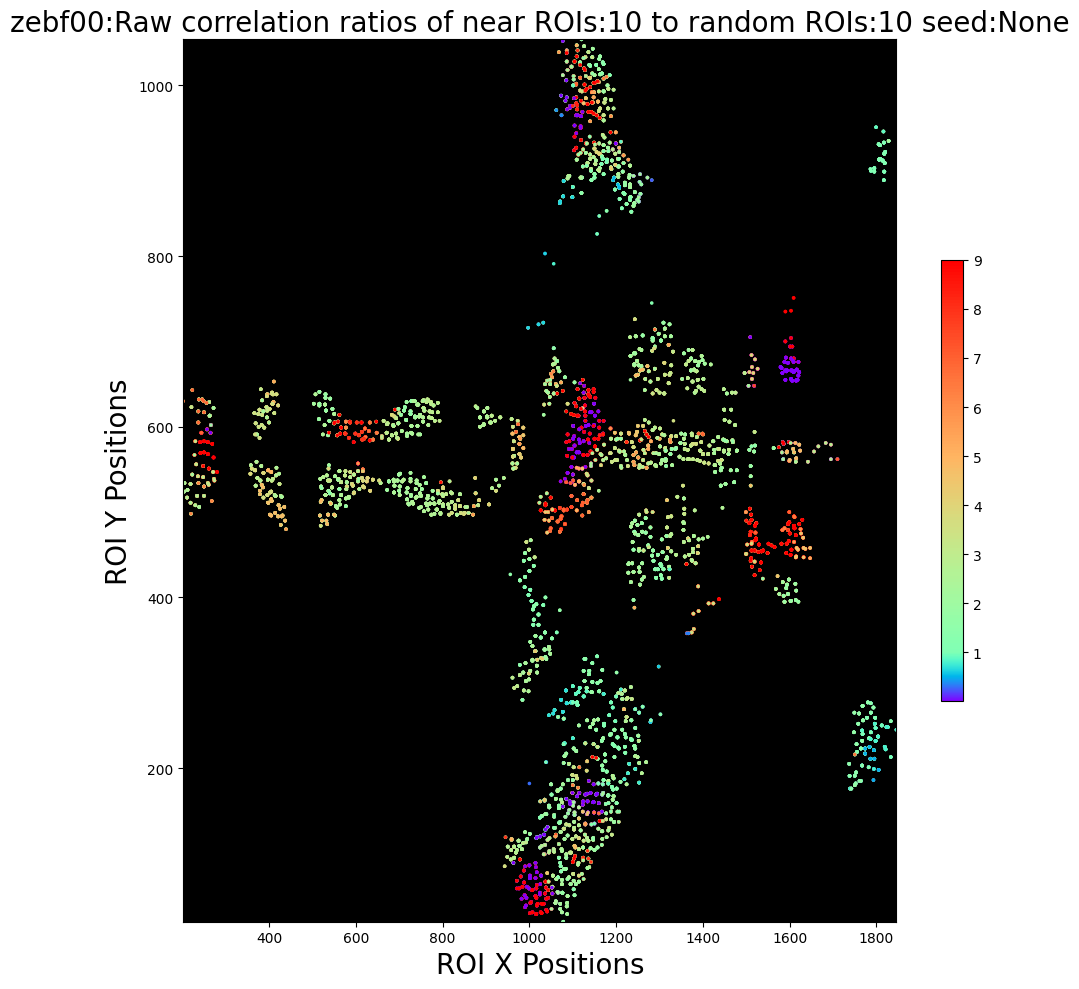

In [61]:
# compute correlation ratio and render plot
compute_render_ratio_corr(
    x,
    y,
    d0=d0,
    dS=dS,
    num_rois=num_rois,
    nnpop=nnpop,
    rnpop=rnpop,
    seed=seed,
    tag=tag,
    sdir=sdir,
)

In [ ]:
# need to fix the scale of colorbar from [min, 1]  ---  fixed 
### colorbar range from [min=0.001, center=1, max=9] tried spacing uniform, proportional both of which are not working.
        ### needed to add set_yscale('linear') to colorbar to fix it.
        ### does colorbar axes only render integer points?
        ### explore different cmap renderings 'rainbow' does not seem suitable.
## verify where bulk of the datasets lies [0.001, 9]

## consider using semantic labels for colorbar


# set radius of scale 
# overlay plot with loose anatomical map
# overlap plot with example signals 

# Set radial scale

*** get roi ( index)
*** get nearnest neighbours distances 
*** get position (x, y) of roi (index); seems to the x[roi_index], y[roi_index]
*** need to verify that the using index to compute distances and using positions yields same results.
***  

In [64]:
find_nearest_nbrs(dS, 0, 10)

array([ 790, 1771, 1779, 1780,  797,  791,  785,  783, 1769,  793])

In [67]:
nn_distances = find_nearest_nbrs_dist(dS, 0, 10)

In [69]:
sum(nn_distances)
matplotlib.patches.Circle(x_roi_indx, y_roi_indx, radius= sum(nn_distances/2000))

1695.5890789992743

In [71]:
# get x, y given roi_index 

10

In [74]:
d0[:, 0]

array([0.1451106 , 0.04709136, 0.12183964, ..., 0.01886123, 0.09211934,
       0.16219246], dtype=float32)

In [76]:
x[0], y[0]

(1163, 1013)

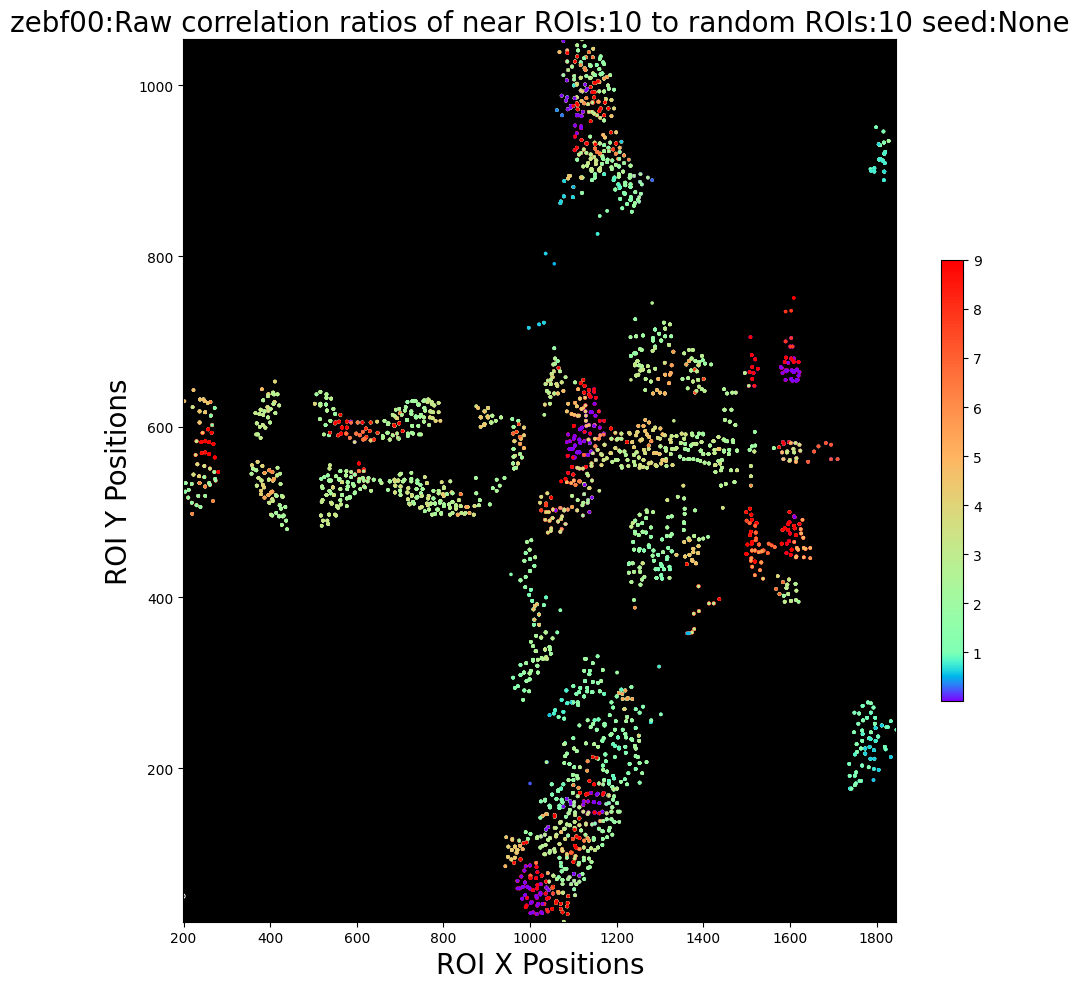

In [120]:
compute_render_ratio_corr(
    x,
    y,
    d0=d0,
    dS=dS,
    num_rois=num_rois,
    nnpop=nnpop,
    rnpop=rnpop,
    seed=seed,
    tag=tag,
    sdir=sdir,
)

# Overlay plot with example signals

*** get some (2/3) roi index for high and low roc  
*** get responses for these ROIs 
*** plot these over the sample plots 

In [ ]:
x, y, d0, dS, num_rois=30000, nnpop=10, rnpop=10, seed=None, tag=None, sdir=None, figsize=(10, 10),
):

# If the data were NOISE

In [25]:
noise_d0 = np.random.randn(2880, 2000)
noise_dS=  np.random.uniform(low=0, high=1688, size=(2000, 2000))
noise_x = np.random.randint(202, 1846,  2000)
noise_y = np.random.randint(20, 1054, 2000)

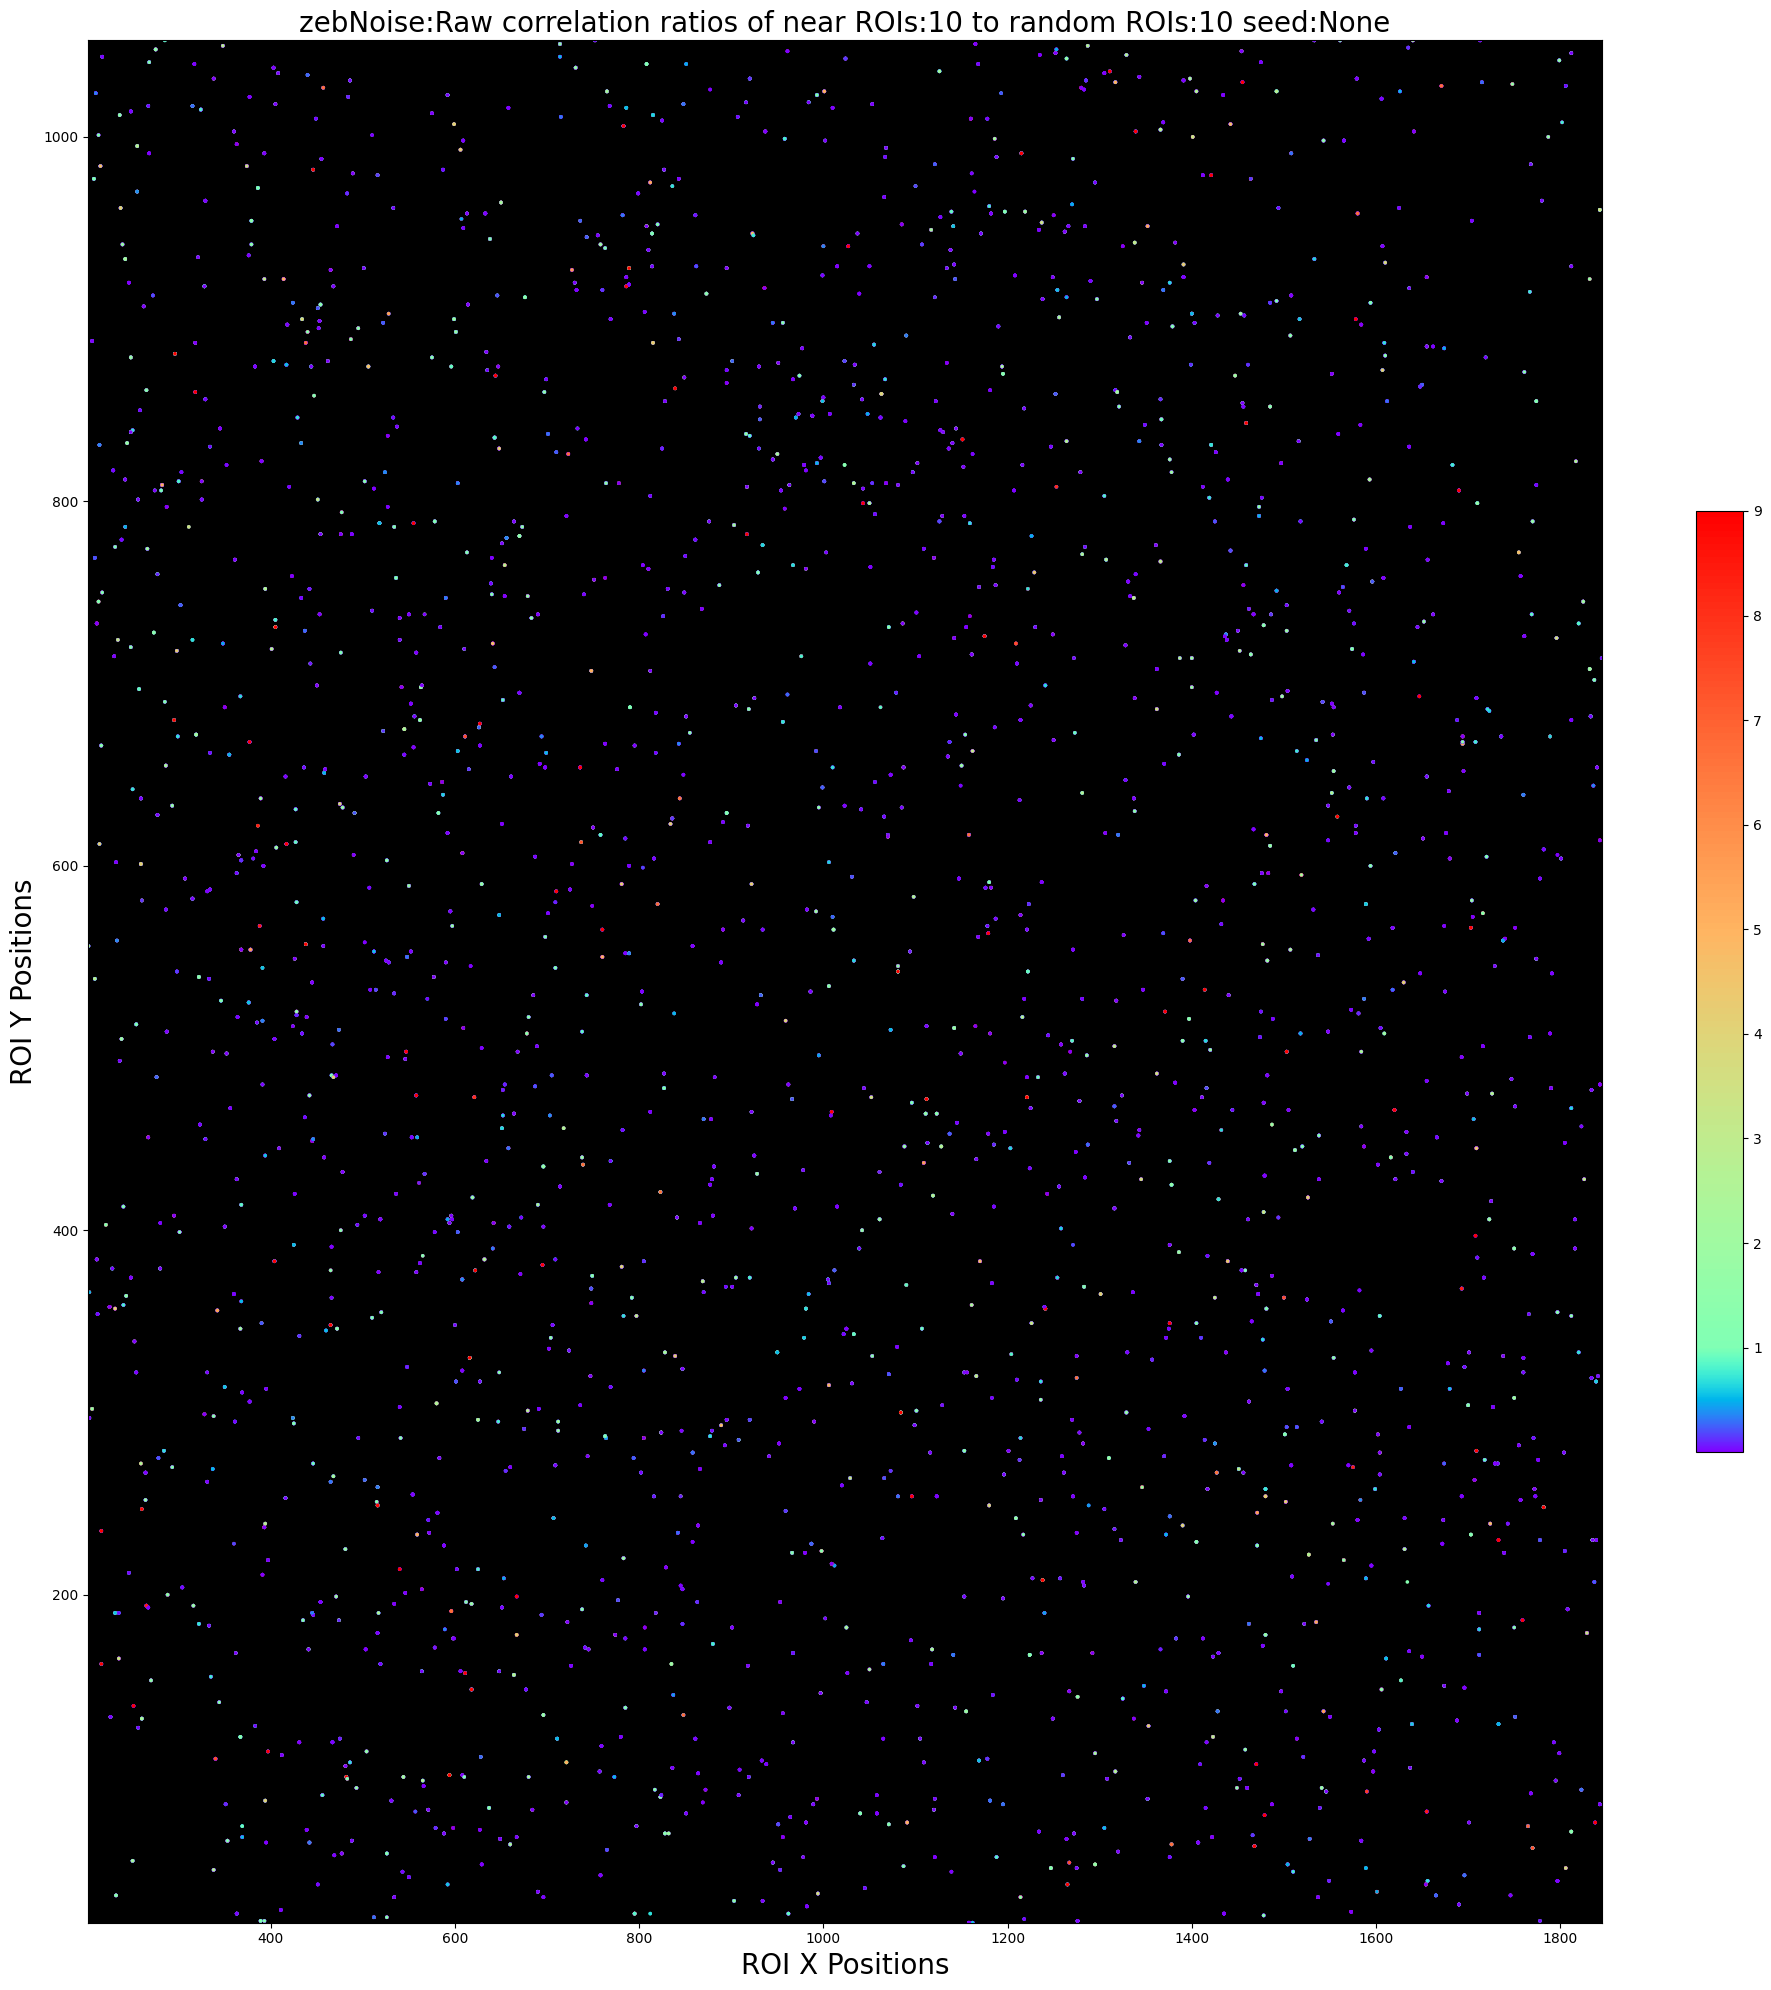

In [31]:
compute_render_ratio_corr(
    noise_x,
    noise_y,
    d0=noise_d0,
    dS=noise_dS,
    num_rois=num_rois,
    nnpop=nnpop,
    rnpop=rnpop,
    seed=seed,
    tag='zebNoise',
    sdir=sdir,
    circle_patch=False, 
    figsize=(20, 20)
)

In [10]:
dSlike = np.empty_like(dS)

(2000, 2000)